In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import pickle
import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
MODEL_FOLDER = "./dl_models/"

In [3]:
!rm -rf $MODEL_FOLDER
!mkdir $MODEL_FOLDER

In [4]:
def previous_window_impute(station_df, window_length=14):
    column = "PM2.5"
    try:
        for idx, value in enumerate(station_df[column].values):
            if np.isnan(value):
                station_df[column][idx] = station_df[column][idx - window_length]
    except:
        pass
    return station_df

In [5]:
def series_to_supervised(data, col_name='PM2.5', input_length=7, output_length=1, dropnan=True):
    features = 1 if type(data) is list else data.shape[1]
    df_new = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(input_length, 0, -1):
        cols.append(df_new.shift(i))
        names += [('%s(t-%d)' % (col_name, i)) for j in range(features)]
        
    for i in range(0, output_length):
        cols.append(df_new.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col_name)) for j in range(features)]
        else:
            names += [('%s(t+%d)' % (col_name, i)) for j in range(features)]
    df_final = pd.concat(cols, axis=1)
    df_final.columns = names
    if dropnan:
        df_final.dropna(inplace=True)
    return df_final

In [6]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
from sklearn.preprocessing import StandardScaler

In [7]:
VERBOSITY = 0

input_layers = 50
epochs = 200
batch_size = 16

In [8]:
def update_model(model, X_train, y_train, batch_size, epochs=1):
    model.fit(X_train, y_train, epochs=epochs, 
                        batch_size=batch_size,
                        shuffle=False, verbose=0)
    return model

def get_predictions(model, batch_size, X_train, y_train, X_test, y_test):
    y_hat = []
    
    for i in range(len(X_test)):
        current_row = X_test[i].reshape(1, 1, X_test[i].shape[-1])
        current_pred = model.predict(current_row)[0]
        y_hat.append(current_pred)
    
        X_train = np.append(X_train[1:], [X_test[i]], axis=0)
        y_train = np.append(y_train[1:], y_test[0])
        
        model = update_model(model, X_train, y_train, batch_size)
    
    return model, y_hat       


def get_MLP_model(X_train, X_test, y_train, y_test):
    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    
    import tensorflow as tf

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)
    
    sc_X = StandardScaler()
    sc_y = StandardScaler()

    X_train_sc = sc_X.fit_transform(X_train)
    y_train_sc = sc_y.fit_transform(y_train)

    X_test_sc = sc_X.transform(X_test)
    y_test_sc = sc_y.transform(y_test)

    X_train_sc = X_train_sc.reshape(X_train_sc.shape[0], 1, X_train_sc.shape[1])
    X_test_sc  = X_test_sc.reshape(X_test_sc.shape[0], 1, X_test_sc.shape[1])
    
    tf.random.set_seed(42)
    
    model = Sequential()
    model.add(Dense(input_layers, input_shape=(X_train_sc.shape[1], X_train_sc.shape[2])))
    model.add(Dense(input_layers//2))
    model.add(Dense(input_layers//4))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    model.fit(X_train_sc, y_train_sc, epochs=epochs, 
            batch_size=batch_size,
            shuffle=False, verbose=VERBOSITY) 
    
    model, y_pred = get_predictions(model, batch_size, X_train_sc, y_train_sc, X_test_sc, y_test_sc)
    y_pred = sc_y.inverse_transform(y_pred)
    y_pred = y_pred.reshape(-1, 1)
    
    score = {
        "r2_score": r2_score(y_test, y_pred),
        "mae": mean_absolute_error(y_test, y_pred), 
        "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
        "mean": np.mean(y_test)
    }
    
    return model, score, (sc_X, sc_y), y_pred

def get_LSTM_AutoEncoder_model(X_train, X_test, y_train, y_test):
    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dropout, Dense, RepeatVector, Bidirectional
    
    import tensorflow as tf

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)
    
    sc_X = StandardScaler()
    sc_y = StandardScaler()

    X_train_sc = sc_X.fit_transform(X_train)
    y_train_sc = sc_y.fit_transform(y_train)

    X_test_sc = sc_X.transform(X_test)
    y_test_sc = sc_y.transform(y_test)

    X_train_sc = X_train_sc.reshape(X_train_sc.shape[0], 1, X_train_sc.shape[1])
    X_test_sc  = X_test_sc.reshape(X_test_sc.shape[0], 1, X_test_sc.shape[1])
    
    tf.random.set_seed(42)
    
    model = Sequential()
    model.add(LSTM(input_layers, input_shape=(X_train_sc.shape[1], X_train_sc.shape[2]), return_sequences=True))
    model.add(LSTM(input_layers//2))
    model.add(RepeatVector(1))
    model.add(LSTM(input_layers//2, return_sequences=True))
    model.add(LSTM(input_layers))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    model.fit(X_train_sc, y_train_sc, epochs=epochs, 
            batch_size=batch_size,
            shuffle=False, verbose=VERBOSITY) 
    
    model, y_pred = get_predictions(model, batch_size, X_train_sc, y_train_sc, X_test_sc, y_test_sc)
    y_pred = sc_y.inverse_transform(y_pred)
    
    score = {
        "r2_score": r2_score(y_test, y_pred),
        "mae": mean_absolute_error(y_test, y_pred), 
        "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
        "mean": np.mean(y_test)
    }
    
    return model, score, (sc_X, sc_y) ,y_pred


def get_LSTM_model(X_train, X_test, y_train, y_test):
    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dropout, Dense, RepeatVector, Bidirectional
    
    import tensorflow as tf

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)
    
    sc_X = StandardScaler()
    sc_y = StandardScaler()

    X_train_sc = sc_X.fit_transform(X_train)
    y_train_sc = sc_y.fit_transform(y_train)

    X_test_sc = sc_X.transform(X_test)
    y_test_sc = sc_y.transform(y_test)

    X_train_sc = X_train_sc.reshape(X_train_sc.shape[0], 1, X_train_sc.shape[1])
    X_test_sc  = X_test_sc.reshape(X_test_sc.shape[0], 1, X_test_sc.shape[1])


    tf.random.set_seed(42)
    
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_sc.shape[1], X_train_sc.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    for i in range(0, input_layers):
        model.add(LSTM(50, return_sequences=True))
        model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    model.fit(X_train_sc, y_train_sc, epochs=epochs, 
            batch_size=batch_size,
            shuffle=False, verbose=VERBOSITY) 
    
    model, y_pred = get_predictions(model, batch_size, X_train_sc, y_train_sc, X_test_sc, y_test_sc)
    y_pred = sc_y.inverse_transform(y_pred)
    
    score = {
        "r2_score": r2_score(y_test, y_pred),
        "mae": mean_absolute_error(y_test, y_pred), 
        "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
        "mean": np.mean(y_test)
    }
    
    return model, score, (sc_X, sc_y) ,y_pred


def get_BiLSTM_model(X_train, X_test, y_train, y_test):
    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dropout, Dense, RepeatVector, Bidirectional
    
    import tensorflow as tf

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)
    
    sc_X = StandardScaler()
    sc_y = StandardScaler()

    X_train_sc = sc_X.fit_transform(X_train)
    y_train_sc = sc_y.fit_transform(y_train)

    X_test_sc = sc_X.transform(X_test)
    y_test_sc = sc_y.transform(y_test)

    X_train_sc = X_train_sc.reshape(X_train_sc.shape[0], 1, X_train_sc.shape[1])
    X_test_sc  = X_test_sc.reshape(X_test_sc.shape[0], 1, X_test_sc.shape[1])

    tf.random.set_seed(42)
    model = Sequential()
    model.add(Bidirectional(LSTM(input_layers, return_sequences=True), input_shape=(X_train_sc.shape[1], X_train_sc.shape[2])))
    model.add(Bidirectional(LSTM(input_layers, return_sequences=True)))
    model.add(LSTM(input_layers))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    model.fit(X_train_sc, y_train_sc, epochs=epochs, 
            batch_size=batch_size,
            shuffle=False, verbose=VERBOSITY) 
    
    model, y_pred = get_predictions(model, batch_size, X_train_sc, y_train_sc, X_test_sc, y_test_sc)
    y_pred = sc_y.inverse_transform(y_pred)
    
    score = {
        "r2_score": r2_score(y_test, y_pred),
        "mae": mean_absolute_error(y_test, y_pred), 
        "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
        "mean": np.mean(y_test)
    }
    
    return model, score, (sc_X, sc_y) ,y_pred

In [9]:
MODEL_LIST = [
    ("Multi Layer Perceptron", get_MLP_model),
    ('BiDirectional LSTM', get_BiLSTM_model),
    ('LSTM AutoEncoder', get_LSTM_AutoEncoder_model),
]

In [10]:
plt.rc('text', usetex=True)  
plt.rc('font', family='sans-serif')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

def line_format(label):
    if (label.day % 15 == 0):
        return f"{label.day}\n{label.month_name()[:3]}"

def perform_modelling(X_train, X_test, y_train, y_test, test_idx_values, 
                      station_data, station_id, 
                      dataset_name, show_graph=True):

    best = {}
    best_score = 9e9

    rows = []

    predictions = {}
    predictions['Actual'] = y_test.reshape(-1)

    for name, model_fn in MODEL_LIST:
        details = {}
        print(f"{station_id} - Getting {name} ...")
        
        model, score, scaler, y_pred = model_fn(X_train, X_test, y_train, y_test)
        row = [f"{name}", score['mae'], score['rmse'], score['r2_score'], score['mean']]
        rows.append(row)

        predictions[name] = y_pred.reshape(-1)
        
        details['station_name'] = station_data[0]
        details['station_id'] = station_id
        details['name'] = name + ""
        details['model'] = model
        details['scaler'] = scaler
        details['score'] = score       
        details['test_set_predictions'] = y_pred
        details['test_set'] = y_test
        
        with open(MODEL_FOLDER + f"{dataset_name}/{name}/{station_id}_pm25.pkl", "wb") as file:
            details_model = details['model']
            details_model.save(MODEL_FOLDER + f"{dataset_name}/{name}/{station_id}_pm25.h5")
            del details['model']
            pickle.dump(details, file, protocol=4)

        if score['rmse'] < best_score:
            best = details
            best['model'] = details_model
            best_score = score['rmse']

    model_dfs = pd.DataFrame(rows, columns=["model", "mae", "rmse", "r2_score", "mean"])
    
    test_idx_values += datetime.timedelta(days=1)
    predictions_df = pd.DataFrame(predictions, index=test_idx_values)
    predictions_df.to_pickle(MODEL_FOLDER + f"{dataset_name}/{station_id}_predictions.pkl")
    
    if show_graph:
        fig = plt.figure(figsize=(18, 4))
        ax = fig.gca()
        
        predictions_df[['Actual', best['name']]].plot(ax=fig.gca())
        plt.title(f"{station_id} | Test Set", fontsize=14)
        plt.ylabel('PM2.5')
#         plt.grid(ls='--')
        
        msg_rmse = f"RMSE: {best['score']['rmse'].round(3)}"
        msg_mae =  f"MAE:  {best['score']['mae'].round(3)}"
        msg_mean = f"MEAN: {best['score']['mean'].round(3)}"
        
        msg = msg_rmse + '\n' + msg_mae + '\n' + msg_mean 
        
        ax.set_xticks(predictions_df.index)
        ax.set_xticklabels(map(line_format, predictions_df.index), rotation=0,  ha="center");
        
        ax.text(0.475, 0.85, msg,
             bbox=dict(facecolor='white', alpha=1),
             horizontalalignment='left',
             verticalalignment='center',
             fontsize=12,
             transform=ax.transAxes)

    return best, model_dfs, predictions_df, ax   

In [11]:
import multiprocessing as mp

manager = mp.Manager()
ax_list = manager.list()

def perform_task(idx, dataset, dataset_name):

    station_dict = dataset[idx]
    station_df = station_dict['df']
    station_data = [station_dict[key] for key in list(station_dict.keys())[:-1]]
    
    station_df.index.freq = 'D'
    station_pm25_df = pd.DataFrame(station_df['PM2.5'])

    reframed_df = series_to_supervised(station_pm25_df, input_length=1)
    reframed_df.index.freq = 'D'

    X = reframed_df.values[:,:-1]
    y = reframed_df.values[:,-1].reshape(-1,1)

    ratio = 0.3
    random_state = 42
    length = X.shape[0]
    limit = (int)(ratio * length)

    X_train, X_test, y_train, y_test = X[:-limit], X[-limit:], y[:-limit], y[-limit:]
    test_idx_values = reframed_df.index.to_pydatetime()[-limit:]

    best, model_dfs, predictions_df, ax = perform_modelling(X_train, X_test, y_train, y_test, test_idx_values, station_data, station_data[1], dataset_name, show_graph=True)
    
    ax_list.append(ax)

#     with open(MODEL_FOLDER + f"{station_id}_pm25.pkl", "wb") as file:
#         best_model = best['model']
#         best_model.save(MODEL_FOLDER + f"{station_id}_pm25.h5")
#         del best["model"]
#         pickle.dump(best, file, protocol=4)

In [12]:
import os

POLLUTANT = "PM2.5"
datasets = [
            "delhi", 
            "seoul", 
            "skopje", 
            "ulaanbaatar"
           ]

pool = mp.Pool(4)

for dataset_name in datasets:

    try:
        os.mkdir(MODEL_FOLDER + dataset_name)               
    except:
        pass
    
    dataset = pickle.load(open(f"./Data/{dataset_name}_dataset.pkl", "rb"))
    
    try:
        for name, model_fn in MODEL_LIST:
            os.mkdir(MODEL_FOLDER + f"{dataset_name}/{name}")
    except:
        pass

    pool.starmap(perform_task, [(idx, dataset, dataset_name) for idx in range(len(dataset))])
    
pool.close()

DL007 - Getting Multi Layer Perceptron ...DL002 - Getting Multi Layer Perceptron ...

DL014 - Getting Multi Layer Perceptron ...DL019 - Getting Multi Layer Perceptron ...

DL019 - Getting BiDirectional LSTM ...
DL007 - Getting BiDirectional LSTM ...
DL002 - Getting BiDirectional LSTM ...
DL014 - Getting BiDirectional LSTM ...
DL019 - Getting LSTM AutoEncoder ...
DL007 - Getting LSTM AutoEncoder ...
DL002 - Getting LSTM AutoEncoder ...
DL014 - Getting LSTM AutoEncoder ...
DL021 - Getting Multi Layer Perceptron ...
DL028 - Getting Multi Layer Perceptron ...
DL031 - Getting Multi Layer Perceptron ...
DL033 - Getting Multi Layer Perceptron ...
DL028 - Getting BiDirectional LSTM ...
DL021 - Getting BiDirectional LSTM ...
DL031 - Getting BiDirectional LSTM ...
DL033 - Getting BiDirectional LSTM ...
DL028 - Getting LSTM AutoEncoder ...
DL021 - Getting LSTM AutoEncoder ...
DL031 - Getting LSTM AutoEncoder ...
DL033 - Getting LSTM AutoEncoder ...
SL111 - Getting Multi Layer Perceptron ...
SL101

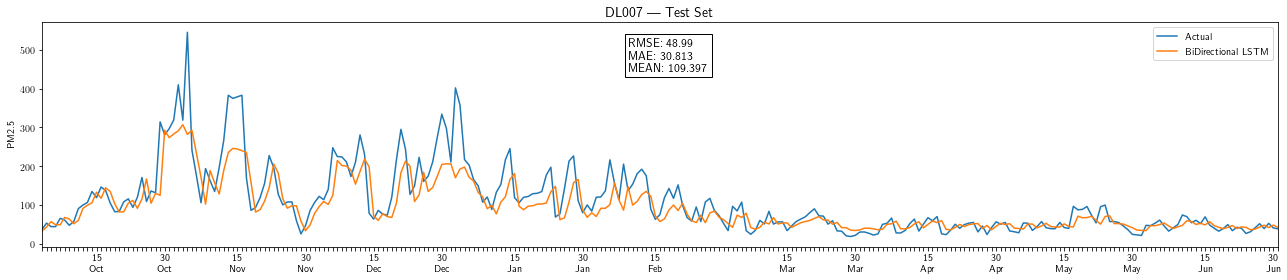

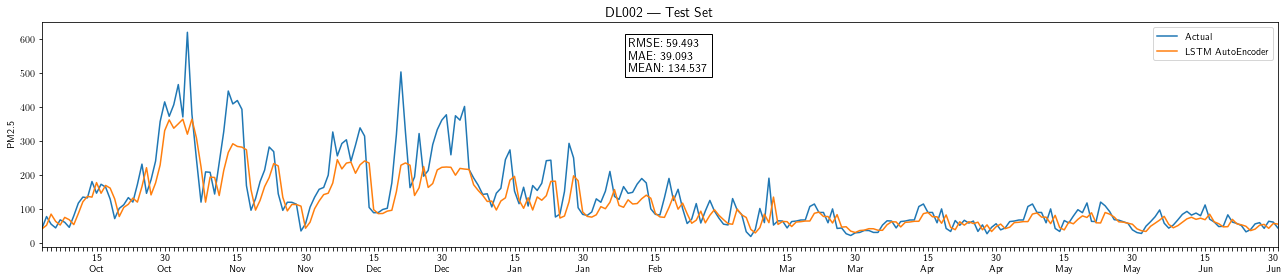

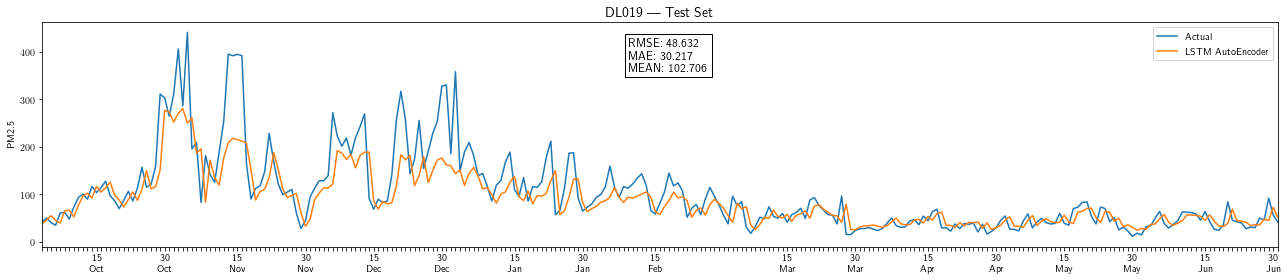

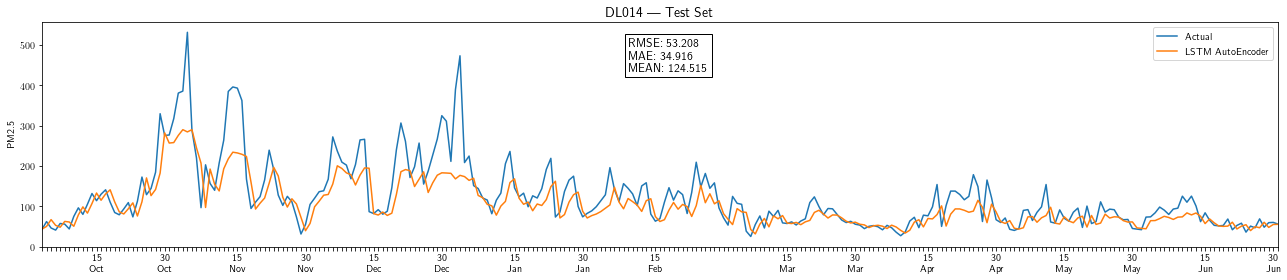

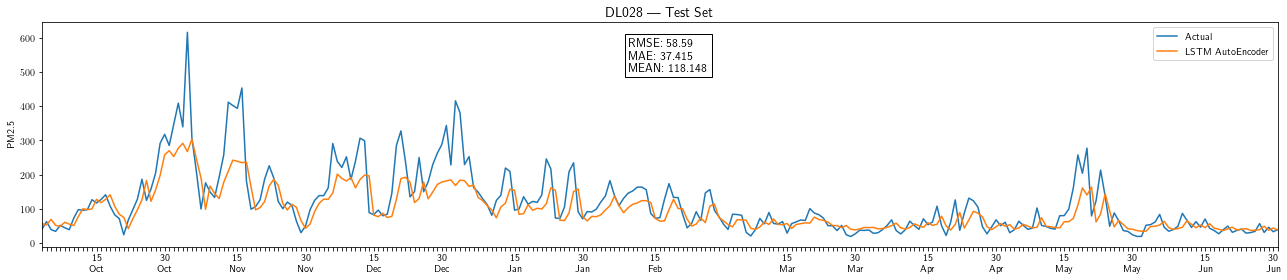

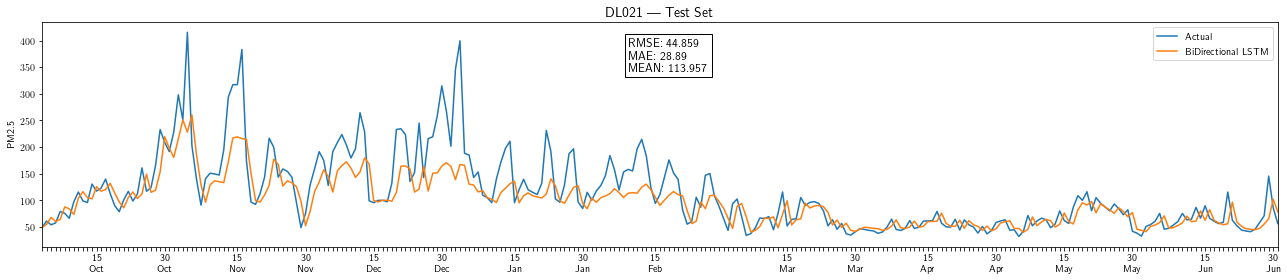

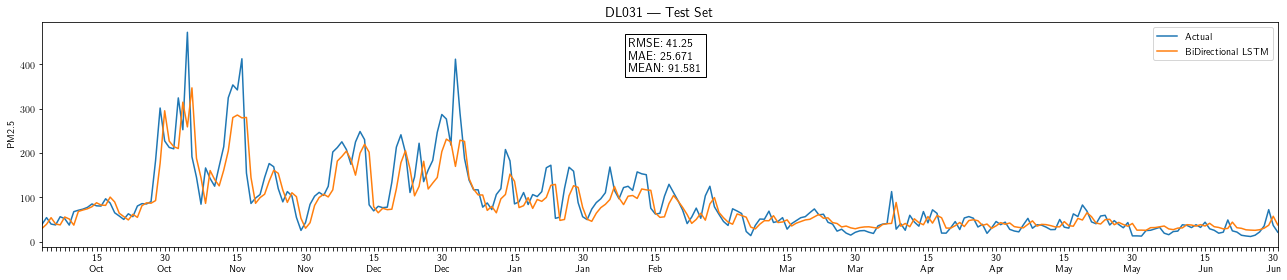

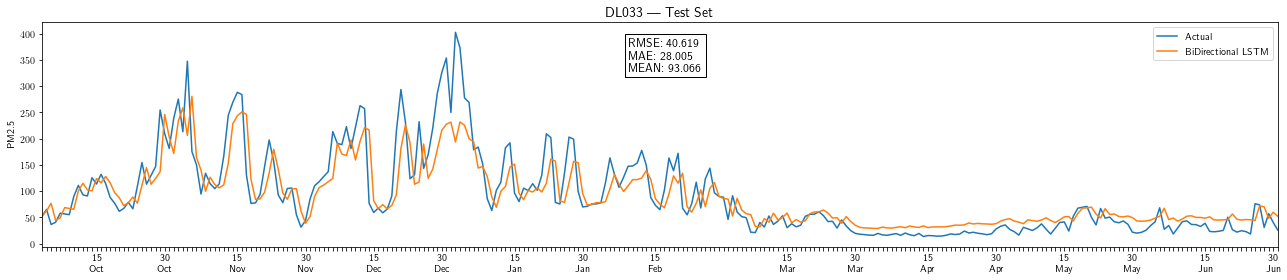

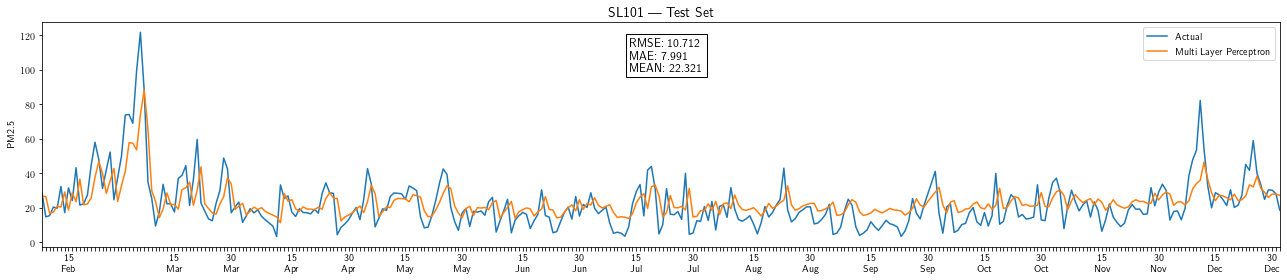

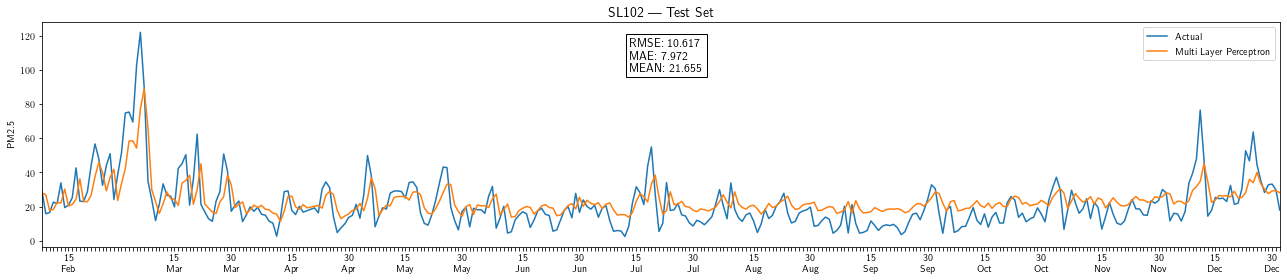

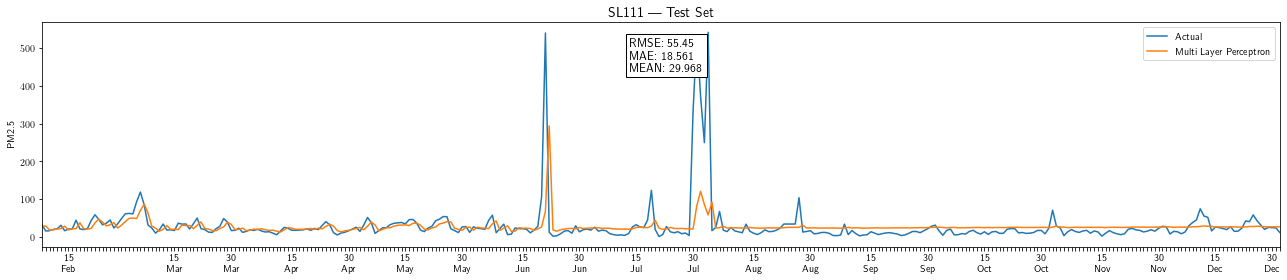

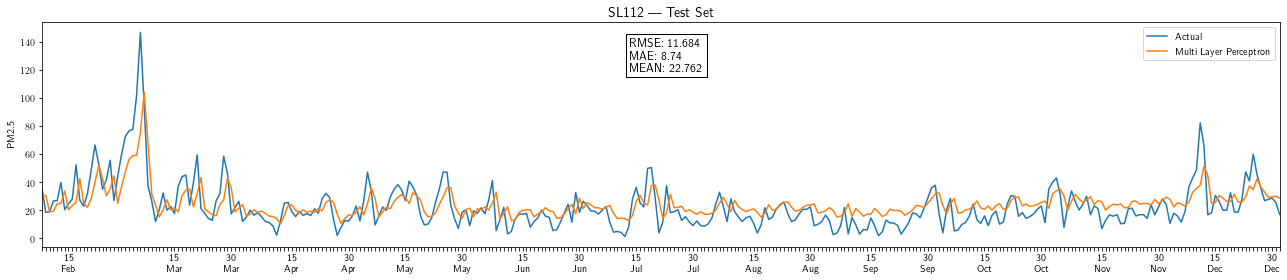

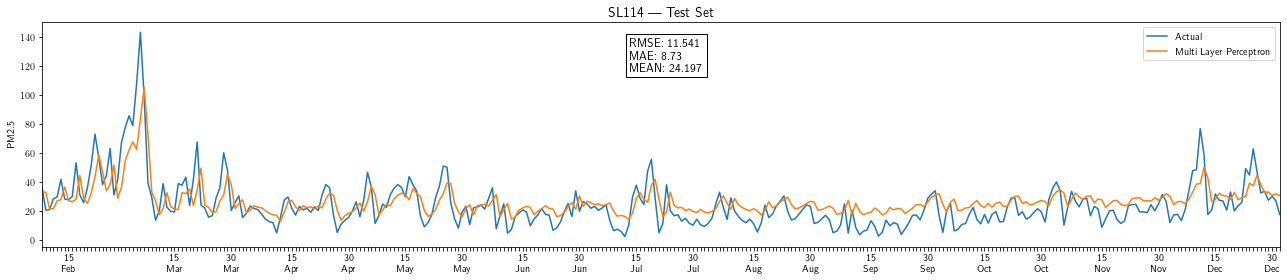

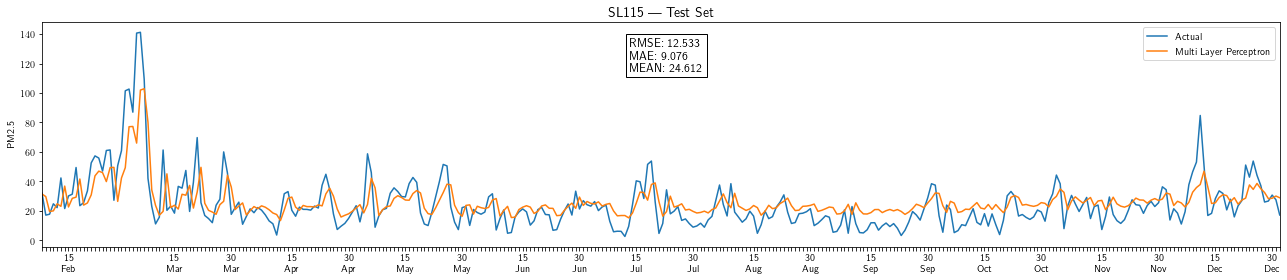

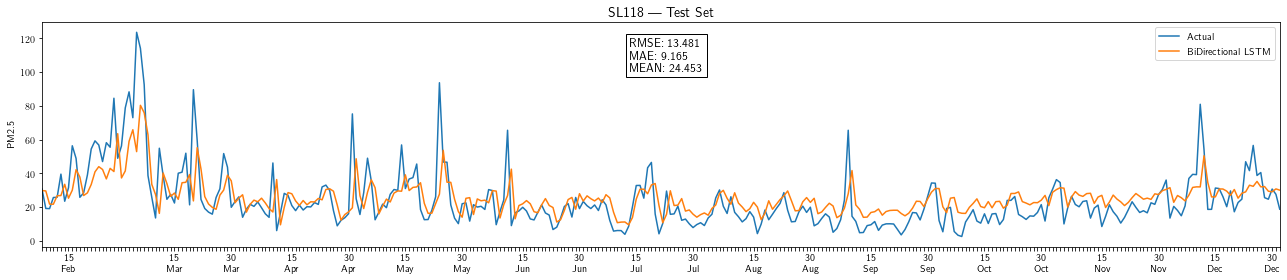

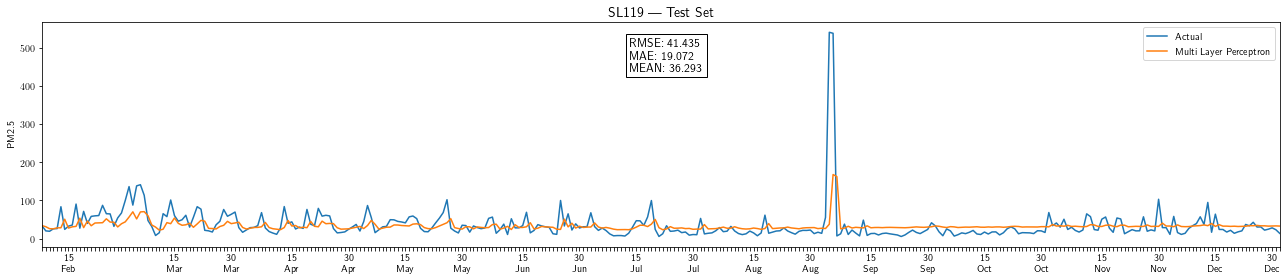

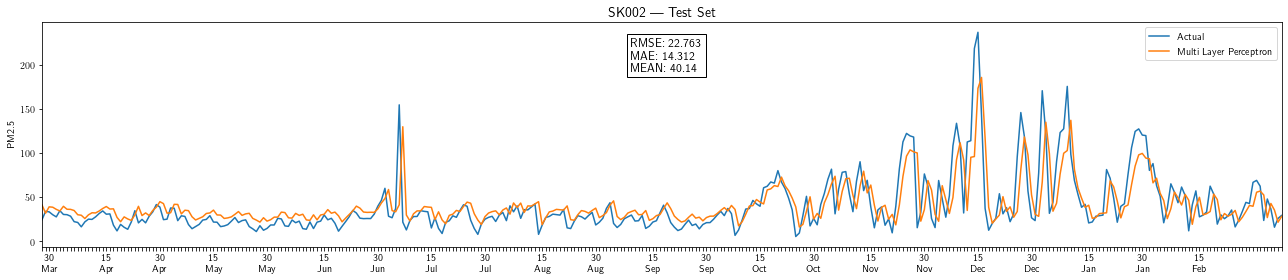

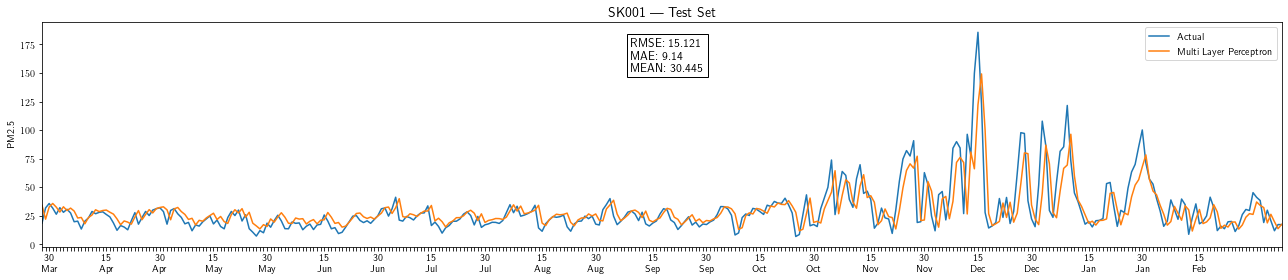

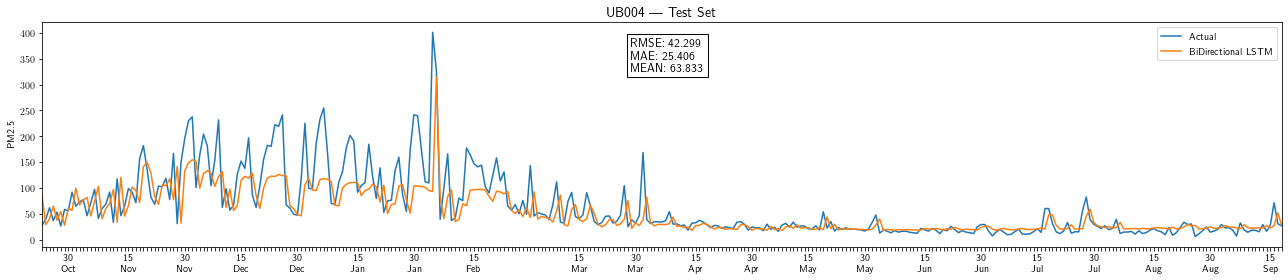

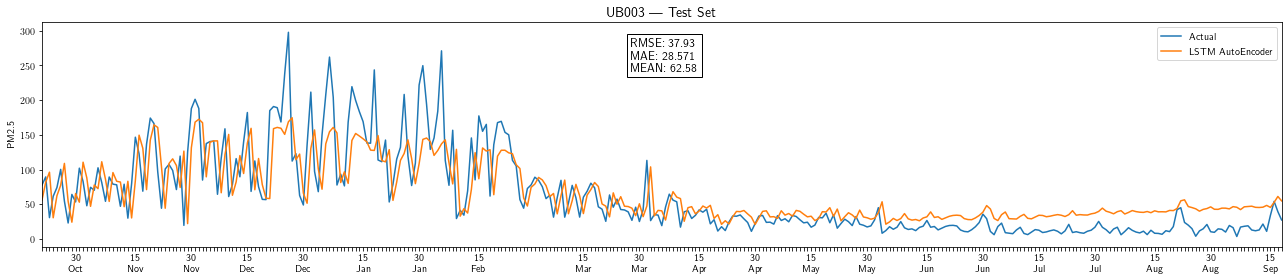

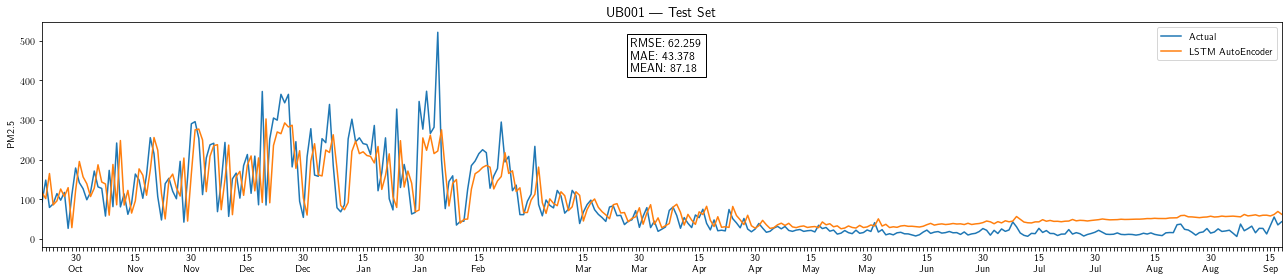

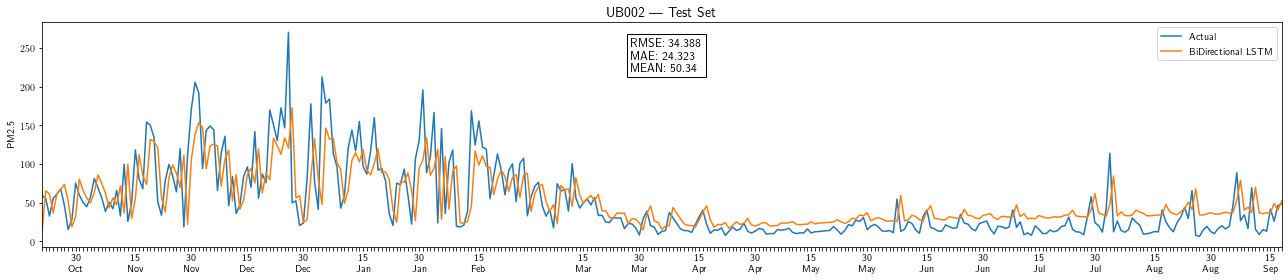

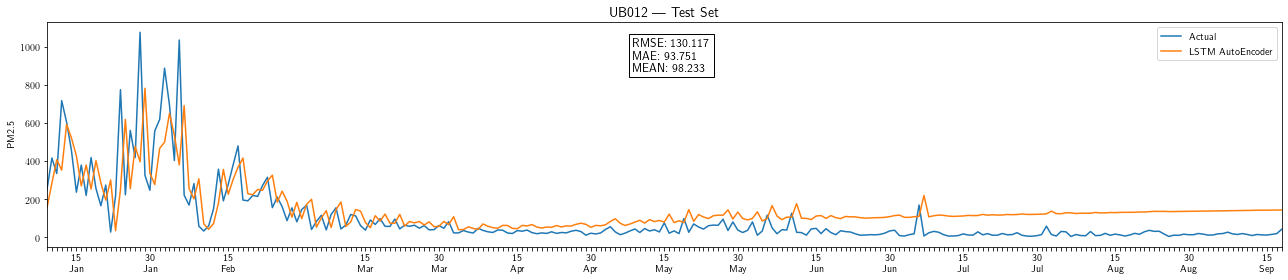

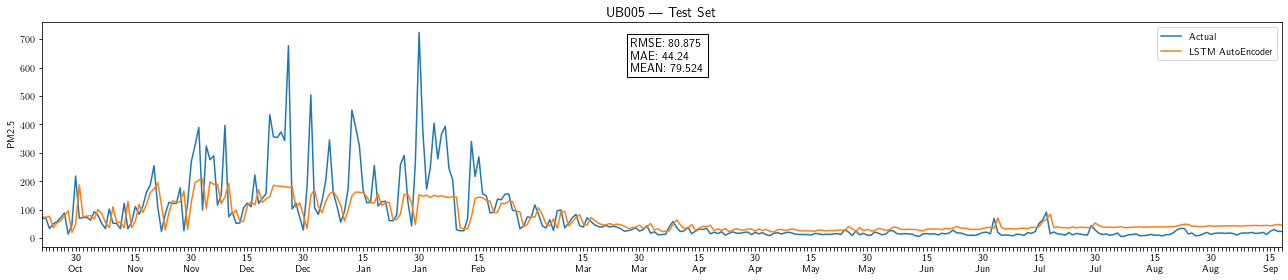

In [13]:
for ax in ax_list:
    plt.show()